In [1]:
import os
import copy
import numpy as np
from PIL import Image
import glob
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid



import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from sklearn.decomposition import PCA, FastICA, DictionaryLearning, MiniBatchDictionaryLearning
from skimage.transform import pyramid_gaussian

In [2]:
class ReadImgDir:
    def __init__(self,
                 path_dir: str,
                 flag_crop: bool = False,
                 size_crop: int = 256,
                 flag_resize: bool = False,
                 scale_resize: float = 0.25):
        self.fname_list_img = glob.glob(path_dir)
        self.fname_list_img.sort()
        self.num_img = len(self.fname_list_img)
        self.flag_crop = flag_crop
        self.size_crop = size_crop
        self.flag_resize = flag_resize
        self.scale_resize = scale_resize
        self.imgs = []
        self.imgs_float = []
        self.size_img = []
        self.labels = []
        print('num of images is ' + str(self.num_img))
        #self.read_imgs_fromdir()

    def read_imgs_fromdir(self):

        for i_list in range(self.num_img):
            print(self.fname_list_img[i_list])
            img = Image.open(self.fname_list_img[i_list])

            if self.flag_resize:
                width, height = img.size
                img = img.resize((int(width*self.scale_resize), int(height*self.scale_resize)))

            self.imgs.append(img)
            self.labels.append(os.path.basename(self.fname_list_img[i_list]))



    def cal_mean_std(self):

        mean_img = []
        std_img = []
        if len(img.shape) == 2:
            mean_img.append(np.mean(img))
            std_img.append(np.std(img))
        else:
            mean_img.append(np.mean(img, 2))
            std_img.append(np.std(img, 2))

    def divide_imgs_col(self, num_divide: int = 4, flag_dif: bool = True, path_save_dir: str =''):
        # this divide each image in the horizontal direction with the number of num_divide.
        # this function will update self.imgs and self.num_img
        # for a specific project I put a function to take a difference from the first image in each cutting.
        # imgs = []
        labels = []
        
        
        ## Only process the Opaque-translucent pairs
        for label in self.fname_list_img:
            if label.partition("_")[2][0] == "O" and label.partition("_to_")[2][0] == "T": ## I added this line
                img = Image.open(label)
                if self.flag_resize:
                    width, height = img.size
                    img = img.resize((int(width*self.scale_resize), int(height*self.scale_resize)))
                width, height = img.size
                cut_shape = int(width/num_divide)
                img = np.array(img)
                img = img.astype('float')
                for i in range(num_divide):
                    img_div = copy.deepcopy(img[:, i * cut_shape: i * cut_shape + cut_shape, :])
                    if flag_dif:
                        if i == 0:
                            img_1 = copy.deepcopy(img_div)
                        else:
                            img_tmp = img_div - img_1 + 128
                            self.imgs_float.append(img_tmp)
                            print('min: ' + str(np.min(img_tmp)) + 'max:' + str(np.max(img_tmp)))
                            img_tmp[np.where(img_tmp < 0)] = 0
                            img_tmp[np.where(img_tmp > 255)] = 255
                            img_tmp = img_tmp.astype('uint8')
                            img_tmp = Image.fromarray(img_tmp)
                            #imgs.append(img_tmp)
                            label_body, ext  = os.path.splitext(os.path.basename(label))
                            labels.append(label_body + '_' + str(i) + ext)
                            self.save_img(path_save_dir, img_tmp, label_body + '_' + str(i) + ext)
                    else:
                        img_tmp = img_tmp.astype('uint8')
                        img_tmp = Image.fromarray(img_tmp)
                        #imgs.append(img_div)
                        label_body, ext = os.path.splitext(os.path.basename(label))
                        labels.append(label_body + '_' + str(i) + ext)
                        self.save_img(path_save_dir, img_tmp, label_body + '_' + str(i) + ext)

        #self.imgs = imgs
        self.size_img = np.array(img_tmp).shape
        self.labels = labels
        self.num_img = self.num_img * num_divide

    def save_img(self, path_save_dir, img, label):
        label, ext = os.path.splitext(label)
        img.save(path_save_dir+label+'.png', format='PNG')

    def save_imgs(self, path_save_dir):
        for i, img in enumerate(self.imgs):
            label, ext = os.path.splitext(self.labels[i])
            img.save(path_save_dir+label+'.png', format='PNG')

    def crop_img(self, img, size_crop):
        h_size_crop = int(size_crop/2)
        size_img = img.shape
        pos_center_x = int(size_img[1]/2)
        pos_center_y = int(size_img[0]/2)
        img = img[pos_center_y-h_size_crop:pos_center_y+h_size_crop,
                            pos_center_x-h_size_crop:pos_center_x+h_size_crop,:]
        return img

    def open_img(self, path, label):
        label_body, ext = os.path.splitext(label)
        return Image.open(path + label_body + '.png')

    def crop_imgs(self, size_crop, path, path_save):
        h_size_crop = int(size_crop/2)
        pos_center_x = int(self.size_img[1]/2)
        pos_center_y = int(self.size_img[0]/2)
        for label in self.labels:
            print(label)
            img = self.open_img(path, label)
            img = img.crop((pos_center_x-h_size_crop,pos_center_y-h_size_crop,
                     pos_center_x+h_size_crop,pos_center_y+h_size_crop))
            self.save_img(path_save, img, label)

    def cut_imgs(self, size_cut, path_save):

        imgs_cut = []
        num_height = int(list_imgs.size_img[0]/size_cut)
        num_width = int(list_imgs.size_img[1] / size_cut)
        count = 0
        for img in self.imgs_float:
            for h in range(num_height):
                for w in range(num_width):
                    count += 1
                    tmp = img[h*size_cut:h*size_cut+size_cut,
                            w*size_cut:w*size_cut+size_cut, :]
                    imgs_cut.append(tmp)
                    tmp = tmp.astype('uint8')
                    tmp = Image.fromarray(tmp)
                    self.save_img(path_save, tmp, str(count))
        self.imgs_float = imgs_cut

In [7]:
def sample_roi(imgs, size_cut, num_patches_per_img, state):
    
    print("shape imgs:",imgs.shape)

    roi = []
    np.random.seed(state)
    for ind_img in range(imgs.shape[0]):
        for ind_patches in range(num_patches_per_img):
            x_start = np.random.randint(0, imgs.shape[2] - size_cut - 1)
            y_start = np.random.randint(0, imgs.shape[1] - size_cut - 1)
            #print(x_start, y_start)
            roi.append(np.reshape(imgs[ind_img, y_start: y_start + size_cut, 
                                  x_start: x_start + size_cut, :],
                                  [size_cut, size_cut, 3]))
    return np.array(roi)

def cal_norm(imgs):
    mean_imgs = np.mean(imgs)
    std_imgs = np.std(imgs)
    imgs_norm = (imgs - mean_imgs)/std_imgs

    return imgs_norm, mean_imgs, std_imgs

def cal_ica(imgs, num_components):
    ica = FastICA(num_components, random_state = 42, tol = 0.1)
    ica.fit(imgs)

    return ica

def cal_dictionary(imgs, num_components):
    dict_learner = DictionaryLearning(n_components=num_components, transform_algorithm='lasso_lars', n_jobs=-1)
    dict_learner.fit(imgs)

    return dict_learner


def cal_dictionary_minibatch(imgs, num_components):
    minidict_learner = MiniBatchDictionaryLearning(n_components=num_components, transform_algorithm='lasso_lars',
                                                  batch_size=10,n_jobs=-1)
    minidict_learner.fit(imgs)

    return minidict_learner

def cal_sequential_sample(path):
    with open(path, mode='rb') as f:
        imgs = pickle.load(f)

    imgs = np.array(imgs)
    imgs = imgs[0:1000, :, :, :]
    size_imgs = imgs.shape

def make_panels(model, num_components, size_imgs, scale_contrast = 2):
    kernels = np.reshape(model.components_, [num_components, size_imgs[1], size_imgs[2], size_imgs[3]])
    print("before transpose:",kernels.shape)
    kernels = kernels - np.min(kernels)
    kernels = kernels / np.max(kernels)
    kernels = scale_contrast*128*(kernels - np.mean(kernels)) + 128
    kernels[np.where(kernels<0)] = 0
    kernels[np.where(kernels>255)] = 255
    kernels = kernels.astype('uint8')
    kernels = kernels.transpose(0, 3, 1, 2)
    print("after transpose:",kernels.shape)
    kernels = torch.from_numpy(kernels)
    
    num_row = 8
    kernels = torchvision.utils.make_grid(kernels, nrow=num_row)
    kernels = kernels.to('cpu').detach().numpy().transpose(1, 2, 0).copy()

    return kernels

def save_kernels(model, num_components, size_imgs):
    kernels = np.reshape(model.components_, [num_components, size_imgs[1], size_imgs[2], size_imgs[3]])
    kernels = kernels.transpose(0, 3, 1, 2)
    kernels = torch.from_numpy(kernels)
    return kernels

In [4]:
def get_patches(imgs, size_cut, num_patches_per_img):
    imgs = sample_roi(imgs, size_cut, num_patches_per_img,)
    size_imgs = imgs.shape
    #reshape
    imgs = np.reshape(imgs,[size_imgs[0], size_imgs[1]*size_imgs[2]*size_imgs[3]])
    print(imgs.shape)
    #normalize
    imgs_norm, mean_imgs, std_imgs = cal_norm(imgs)
    
    return imgs_norm

def get_norm_patches(imgs, size_cut, type_model, num_patches_per_img, panel_save, kernel_save_path, num_components = 100, rand_state=42):
    imgs = sample_roi(imgs, size_cut, num_patches_per_img, rand_state)
    size_imgs = imgs.shape
    #reshape
    imgs = np.reshape(imgs,[size_imgs[0], size_imgs[1]*size_imgs[2]*size_imgs[3]])
    #normalize
    imgs_norm, mean_imgs, std_imgs = cal_norm(imgs)
    
    print(type_model)
    
    if type_model=='ica':
        model = cal_ica(imgs_norm, num_components)
    elif type_model=='minidict':
        model = cal_dictionary_minibatch(imgs_norm, num_components)
    elif type_model == 'sparse':
        model = cal_dictionary(imgs_norm, num_components)
        
    scale_contrast = 6
    panels = make_panels(model, num_components, size_imgs, scale_contrast)
    
    kernels = save_kernels(model, num_components, size_imgs)

    panels = panels.astype('uint8')
    panels = Image.fromarray(panels)
    panels.save(panel_save)
    
    ## Save Sparse coding kernels
    kernels_save = copy.deepcopy(kernels)
    np.save(kernel_save_path,kernels_save)
    

def get_imgs(img_path):
    ## Get a list of images from directory
    
    img_names = glob.glob(img_path)

    imgs = []
    for label in img_names:
        print(label)
        img = Image.open(label)
        img_norm = trans_for_conv(img)
        imgs.append(img_norm)
        
    return imgs, img_names

def show_kernel(kernels):
    scale_contrast = 1
    kernels = kernels - np.min(kernels)
    kernels = kernels / np.max(kernels)
    kernels = scale_contrast*128*(kernels - np.mean(kernels)) + 128
    kernels[np.where(kernels<0)] = 0
    kernels[np.where(kernels>255)] = 255
    kernels = kernels.astype('uint8')
    
    return kernels


def conv_3d(img, kernel, scalecontrast=2):
    ## Apply 3D convolution of a learned kernel to the image
    
    H, W = kernel.shape[1], kernel.shape[2] ## H, W = 24, 24
    kernel = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).expand(1, 1, 3, H, W)
    
    out = F.conv3d(img, kernel, stride=1, padding="same", groups=1)
    out = out.squeeze().numpy().transpose(1, 2, 0)
   
    out = scalecontrast*128*(out - np.mean(out)) + 128
    out[np.where(out<0)] = 0
    out[np.where(out>255)] = 255
    out = out.astype('uint8')

    feature_map = Image.fromarray(out, 'RGB')
    
    return feature_map

def save_kernels_conv(img, kernels,scale_constrast, save_path=None):
    feature_maps = []
    for i in range(kernels.shape[0]):
        feature_map_i = plot_feature(img, kernels,i, scale_constrast)
        feature_maps.append(feature_map_i)
    
    return feature_maps

def plot_selected_kernels_conv(img, kernels, kernel_num, scale_constrast):
    
    feature_maps = []
    for i in kernel_num:
        print("Kernel:", i)
        kernel_i =  show_kernel(kernels[i])
        plt.imshow(kernel_i.transpose(1, 2, 0))
        plt.axis('off')
        plt.show()
        feature_map_i = plot_feature(img, kernels, i, scale_constrast)
        plt.imshow(feature_map_i)
        plt.axis('off')
        plt.show()
    

def plot_feature(img, kernel,kernel_id, scale_constrast):
    kernel = kernel[kernel_id]
    feature_map = conv_3d(img,kernel,scale_constrast)
    
    return feature_map


def plot_kernels(kernel_img_list, figname):
    n_row = 8
    n_col = 8
    fig, axs = plt.subplots(figsize=(20, 20))
    axs.set_axis_off()
    
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes
                     share_all=True,
                     )

    for i in range(len(kernel_img_list)):
        grid[i].axis('off')
        grid[i].imshow(kernel_img_list[i])
        

    plt.show()
    #fig.axis('off')

    fig.savefig(figname)
    

## Process middle layer style mix images

In [5]:
## Resize images to 512 x 512
scale_resize = 0.5
width, height = 1024, 1024

In [132]:
filelist_high_res32 = glob.glob('../middle_layer_mix_trbg_top40/res32_trgb_high/*.jpg') 
middle_layer_high_res32 = np.array([np.array(Image.open(fname).resize((int(width*scale_resize), int(height*scale_resize)))) for fname in filelist_high_res32])
middle_layer_high_res32.shape

In [66]:
filelist_high_res64 = glob.glob('../middle_layer_mix_trbg_top40/res64_trgb_high/*.jpg') 
middle_layer_high_res64 = np.array([np.array(Image.open(fname).resize((int(width*scale_resize), int(height*scale_resize)))) for fname in filelist_high_res64])
middle_layer_high_res64.shape

(3160, 512, 512, 3)

In [67]:
## Random sample from 3160 image
#imgs_high = middle_layer_high[0:3160, :, :, :]
imgs_high_res64 = middle_layer_high_res64


In [9]:
#imgs_high_res16 = middle_layer_high_res16
n = 1000  # for 2 random indices
index = np.random.choice(middle_layer_high_res16.shape[0], n, replace=False)  
imgs_high_res16 = middle_layer_high_res16[index]
imgs_high_res16.shape

(1000, 512, 512, 3)

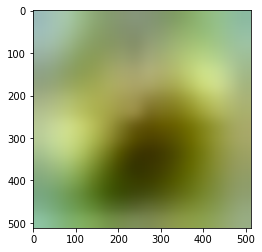

In [11]:
plt.imshow(imgs_high_res64[0])
plt.show()


# Run ICA (Figure 7)

In [229]:
## ICA for 32 res trgb (early-layers)
patch_size = 48 ## Size of image patch
seed = 100      ## Random seed for ICA

high_trans_panel_fname = '../feature_kernels/patch24_res32_high_trans_ica_random_state' + str(seed) +'.png'
high_trans_kernel_fname = '../feature_kernels/patch24_res32_high_trans_ica_random_state' + str(seed) + '.npy'
get_norm_patches(imgs_high, size_cut=patch_size,type_model="ica",num_patches_per_img=10, panel_save=high_trans_panel_fname, kernel_save_path=high_trans_kernel_fname, num_components = 160, rand_state=seed)

shape imgs: (3160, 512, 512, 3)
(31600, 6912)
ica
before transpose: (100, 48, 48, 3)
after transpose: (100, 3, 48, 48)


In [114]:
## ICA for 64 res trgb (middle-layers)

patch_size = 24
seed = 500
num_comp = 64

high_trans_panel_fname = '../feature_kernels/patch24_res64_high_trans_ica_random_state' + str(seed) + str(num_comp)+'component.png'
high_trans_kernel_fname = '../feature_kernels/patch24_res64_high_trans_ica_random_state' + str(seed) +str(num_comp) + 'component.npy'
get_norm_patches(imgs_high_res64, size_cut=patch_size,type_model="ica",num_patches_per_img=10, panel_save=high_trans_panel_fname, kernel_save_path=high_trans_kernel_fname, num_components = num_comp, rand_state=seed)

shape imgs: (3160, 512, 512, 3)
(31600, 1728)
ica
before transpose: (64, 24, 24, 3)
after transpose: (64, 3, 24, 24)


## Plot convolution

In [54]:
trans_for_conv = transforms.Compose([
        transforms.Resize(512),                 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    

In [77]:
# ica_kernels_high = np.load("../feature_kernels/top40_high_trans_ica_feature_without_norm_random_state42.npy")
# ica_kernels_low = np.load("../feature_kernels/top40_low_trans_ica_feature_without_norm_random_state42.npy")

# ica_kernels_high = np.load("../feature_kernels/patch24_top50_high_trans_ica_feature_random_state44.npy")
# ica_kernels_low = np.load("../feature_kernels/patch24_top50_low_trans_ica_feature_random_state44.npy")


ica_kernels_high = np.load("../feature_kernels/patch24_res32_high_trans_ica_random_state100.npy")
ica_kernels_high.shape

ica_kernels_high_16res = np.load("../feature_kernels/patch24_res16_high_trans_ica_random_state4464component.npy")
ica_kernels_high_16res.shape

ica_kernels_high_64res = np.load("../feature_kernels/patch24_res64_high_trans_ica_random_state4464component.npy")
ica_kernels_high_64res.shape

(64, 3, 24, 24)

In [15]:
## Get the lists of real and encoded images
path_to_generated_img = '../compare-translucency2/*'

generated_imgs,_ = get_imgs(path_to_generated_img)

../compare-translucency2/IMG_6698.jpg
../compare-translucency2/IMG_2104.jpg
../compare-translucency2/IMG_4969.jpg
../compare-translucency2/soap18_IMG_2215.jpg
../compare-translucency2/soap51_IMG_8085.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


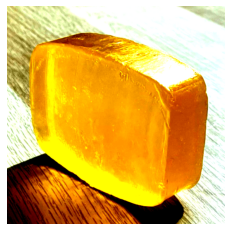

In [110]:
test_img = generated_imgs[4]
plt.imshow(np.array(test_img).transpose(1,2,0))
plt.axis('off')

test_img = test_img.expand(1,1,3,512,512)


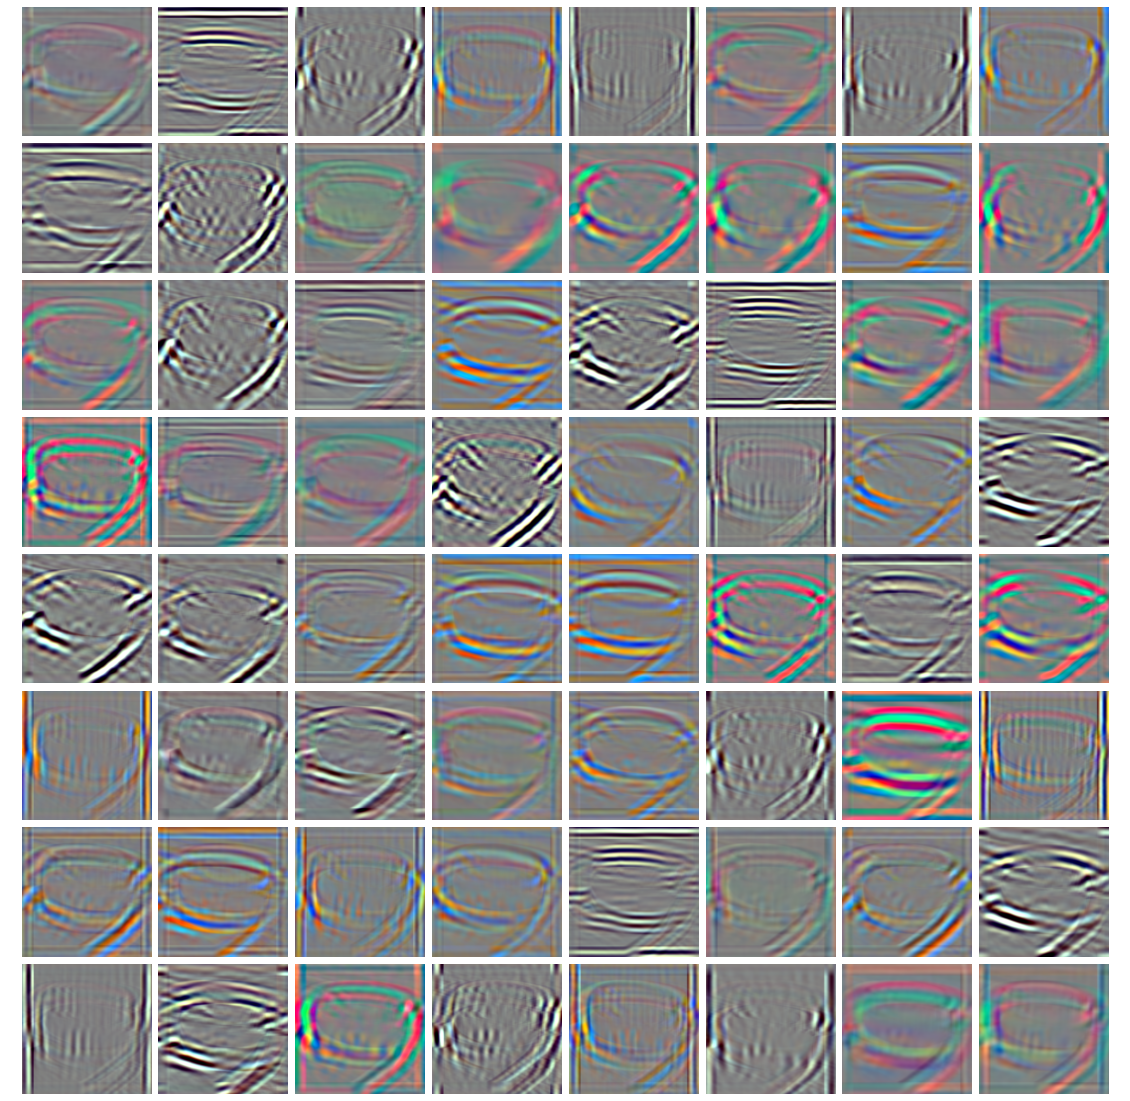

In [55]:
ica_save_path = '../feature_kernels/ica_roundgreen_soap2_high_res16_64comp'

scale_contrast = 2
ica_kernels_res16_conv = save_kernels_conv(test_img, ica_kernels_high_16res, scale_contrast)
plot_kernels(ica_kernels_res16_conv, ica_save_path)

Kernel: 19


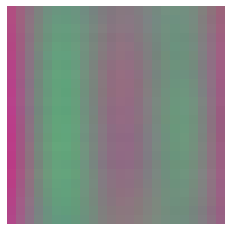

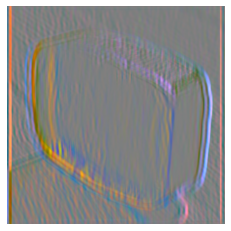

Kernel: 24


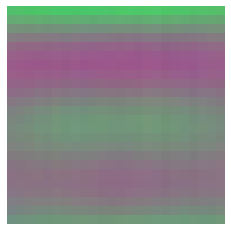

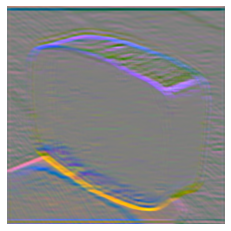

Kernel: 52


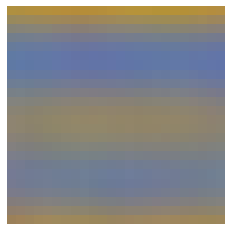

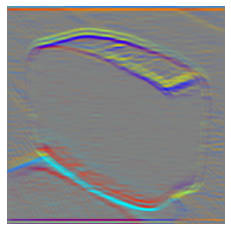

Kernel: 63


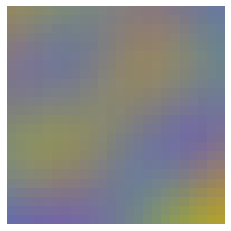

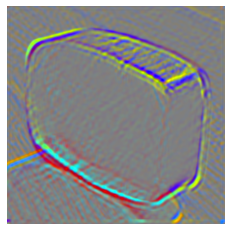

Kernel: 45


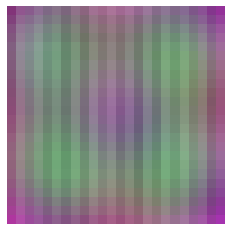

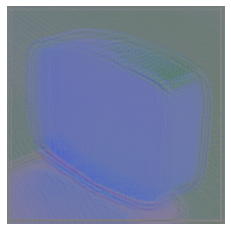

In [111]:
#plot_selected_kernels_conv(test_img, ica_kernels_high, [44,73,84,88,97])
#plot_selected_kernels_conv(test_img, ica_kernels_high, [42,57,28,51,99])
#plot_selected_kernels_conv(test_img, ica_kernels_high, [12,37,25,49,2, 20], 5)
#plot_selected_kernels_conv(test_img, ica_kernels_high, [23,84,36,26,47], 5)
#plot_selected_kernels_conv(test_img, ica_kernels_high_16res, [1, 13, 30], 1)
plot_selected_kernels_conv(test_img, ica_kernels_high_64res, [19, 24, 52, 63, 45], 5)